#### Import all the required libraries

In [78]:
import pandas as pd
import os
import networkx as nx
import itertools
from netwulf import visualize
import netwulf as nw
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib

In [84]:
os.getcwd()
os.chdir("..")
os.chdir(r"..\data")

#### Read the dataset into dataframe

In [12]:
author_df = pd.read_csv(r"C:\Users\mansj\IQL\salt\data\salt_cont_author.csv")
article_list = pd.read_csv(r"C:\Users\mansj\IQL\salt\data\article_list.csv")

In [13]:
author_df.head()

ID                                              title author_given_name  \
0   1  Systematic review of long term effects of advi...               Lee   
1   1  Systematic review of long term effects of advi...       Christopher   
2   1  Systematic review of long term effects of advi...      George Davey   
3   1  Systematic review of long term effects of advi...              Shah   
4   2  Reduced dietary salt for prevention of cardiov...                L.   

  author_surname    author_id organizational_author  manual  
0         Hooper  57202855325                   NaN   False  
1       Bartlett  57194377301                   NaN   False  
2          Smith  35354080500                   NaN   False  
3        Ebrahim   7102093023                   NaN   False  
4         Hooper  57202855325                   NaN   False

In [14]:
article_list.head()

ID      short_name               type study_groupings  \
0   1      Hooper2002  Systematic Review             NaN   
1   2      Hooper2003  Systematic Review             NaN   
2   3      Hooper2004  Systematic Review             NaN   
3   4  Strazzullo2009  Systematic Review             NaN   
4   5     Taylor2011a  Systematic Review             NaN   

                                               title  year      attitude  \
0  Systematic review of long term effects of advi...  2002  inconclusive   
1  Reduced dietary salt for prevention of cardiov...  2003  inconclusive   
2  Advice to reduce dietary salt for prevention o...  2004  inconclusive   
3  Salt intake, stroke, and cardiovascular diseas...  2009           for   
4  Reduced dietary salt for the prevention of car...  2011  inconclusive   

                              doi retracted(Y/N)       study_design  
0        10.1136/bmj.325.7365.628            NaN  Systematic Review  
1       10.1002/14651858.CD003656            NaN  Systematic Review  
2  10.1002/14651858.CD003656.pub2            NaN  Systematic Review  
3               10.1136/bmj.b4567            NaN  Systematic Review  
4            10.1038/ajh.2011.115            NaN  Systematic Review

#### New column in the dataframe for author full_name.

In [15]:
author_df["full_name"] = author_df['author_given_name'] + " " + author_df['author_surname'].fillna('')
author_df.head()
com_df = pd.DataFrame(author_df.groupby('ID')['full_name'].apply(list))
com_df.head()

full_name
ID                                                   
1   [Lee Hooper, Christopher Bartlett, George Dave...
2   [L. Hooper, C. Bartlett, G. Davey Smith, S. Eb...
3   [Lee Hooper, Christopher Bartlett, George Dave...
4   [Pasquale Strazzullo, Lanfranco D'Elia, Ngiang...
5   [Rod S. Taylor, Kate E. Ashton, Tiffany Moxham...

#### Replace the names of author with similar id to the selected key (author name) in the dictionary

In [16]:
list_authors  = pd.DataFrame(author_df.groupby('author_id')['full_name'].apply(list))
auth_list = list_authors.full_name.to_list()

auth_dict = dict()

for i in auth_list:
    i = list(set(i))
    if len(i) > 1:
        auth_dict[i[0]] = i[1:]

#### Function replaces the names of author with same id with the selected key in the dictionary
def replace(auth_name, final_dict):
    for k, v in final_dict.items():
        if auth_name in v:
            auth_name = k
            
    return auth_name
    

author_df.full_name = author_df.full_name.apply(lambda x : replace (x, auth_dict))

#### Check if the author full name is similar in each occurence of the author id 

In [17]:
author_df[author_df.author_id == 57202855325]

ID                                              title author_given_name  \
0     1  Systematic review of long term effects of advi...               Lee   
4     2  Reduced dietary salt for prevention of cardiov...                L.   
8     3  Advice to reduce dietary salt for prevention o...               Lee   
19    5  Reduced dietary salt for the prevention of car...               Lee   
27    9  Effect of lower sodium intake on health: syste...               Lee   
449   6  Reduced dietary salt for the prevention of car...               Lee   

    author_surname    author_id organizational_author  manual   full_name  
0           Hooper  57202855325                   NaN   False  Lee Hooper  
4           Hooper  57202855325                   NaN   False  Lee Hooper  
8           Hooper  57202855325                   NaN   False  Lee Hooper  
19          Hooper  57202855325                   NaN   False  Lee Hooper  
27          Hooper  57202855325                   NaN   False  Lee Hooper  
449         Hooper  57202855325                   NaN   False  Lee Hooper

#### Merge the dataframe to get the author pairs and the title with type of publication they have co-authored 

In [18]:
merged_type_df = pd.merge(com_df, article_list, how = "inner", left_on="ID", right_on="ID")
merged_type_df = merged_type_df[["ID", "full_name","title", "type",]]
merged_type_df.rename(columns={"Our ID":"ID", "type":"item_type", "Title" :"title"}, inplace=True)

new  = []
for i in range(1,len(merged_type_df["ID"])):
    name = merged_type_df["full_name"].loc[i]
    type_t = merged_type_df["item_type"].loc[i]
    if len(name) >= 2:
        for subset in itertools.combinations(name,2):
            if len(subset) == 2:
                new.append({"auth":subset, "type":type_t})
                
df = pd.DataFrame(new)

#### Calculate the review percent 
#### i.e. if the pair of authors mostly worked together on systematic review articles or others( 'RCT', 'Cohort', 'Case Control')

In [19]:
new  = {}
r_count = 0
i_count = 0
for i in range(1,len(merged_type_df)):
    name = merged_type_df["full_name"].loc[i]
    type_t = merged_type_df["item_type"].loc[i]
    if type_t == "Systematic Review":
        r_count = 1
    else:
        i_count = 1
    if len(name) >= 2:
        for subset in itertools.combinations(name,2):
            if len(subset) == 2:
                
                subset = tuple(sorted(subset))
                
                if subset not in new.keys():
                    new[subset] = (r_count, i_count)
                else:
                    new[subset] = (new[subset][0] + r_count, new[subset][1] + i_count)
                    
#                 new.append({"auth":subset, "type":type_t})

#### Dataframe with the author group, count of each systematic review or other article and the systematic review percent

In [21]:
df = pd.DataFrame(new.items(), columns=['authors','counts'])
df[['reviews', 'included']] = pd.DataFrame(df['counts'].tolist(), index=df.index)
df[['auth_1', "auth_2"]] = pd.DataFrame(df['authors'].tolist(), index = df.index)
df['total'] = df['reviews'] + df['included']
df['review_percent'] = round(df['reviews']/df['total'] ,3)
df.head()

authors  counts  reviews  included          auth_1  \
0       (C. Bartlett, L. Hooper)  (1, 0)        1         0     C. Bartlett   
1    (G. Davey Smith, L. Hooper)  (1, 0)        1         0  G. Davey Smith   
2        (L. Hooper, S. Ebrahim)  (1, 0)        1         0       L. Hooper   
3  (C. Bartlett, G. Davey Smith)  (1, 0)        1         0     C. Bartlett   
4      (C. Bartlett, S. Ebrahim)  (1, 0)        1         0     C. Bartlett   

           auth_2  total  review_percent  
0       L. Hooper      1             1.0  
1       L. Hooper      1             1.0  
2      S. Ebrahim      1             1.0  
3  G. Davey Smith      1             1.0  
4      S. Ebrahim      1             1.0

#### Create a graph from the dataframe along with edge attributes as the review_percent
- Get top 4 connected component from the graph and create a new graph of these nodes

In [27]:
G = nx.from_pandas_edgelist(df, "auth_1", "auth_2", edge_attr='review_percent', create_using=nx.Graph())

#Retreives the most connected component
giant = max(nx.connected_components(G), key=len)

#Retrives the top four connected components
top_four = sorted(nx.connected_components(G), key=len, reverse=True)[1:4]

top_list = []
for i in top_four:
    for j in i:
        top_list.append(j)
        
# Create a graph for the nodes retrieved from the top four connected components    
N = nx.Graph()
for node in G.nodes():
    if node in top_list:
        for k, v in G.edges(node):
            N.add_edge(k,v, weight = G[k][v]["review_percent"])



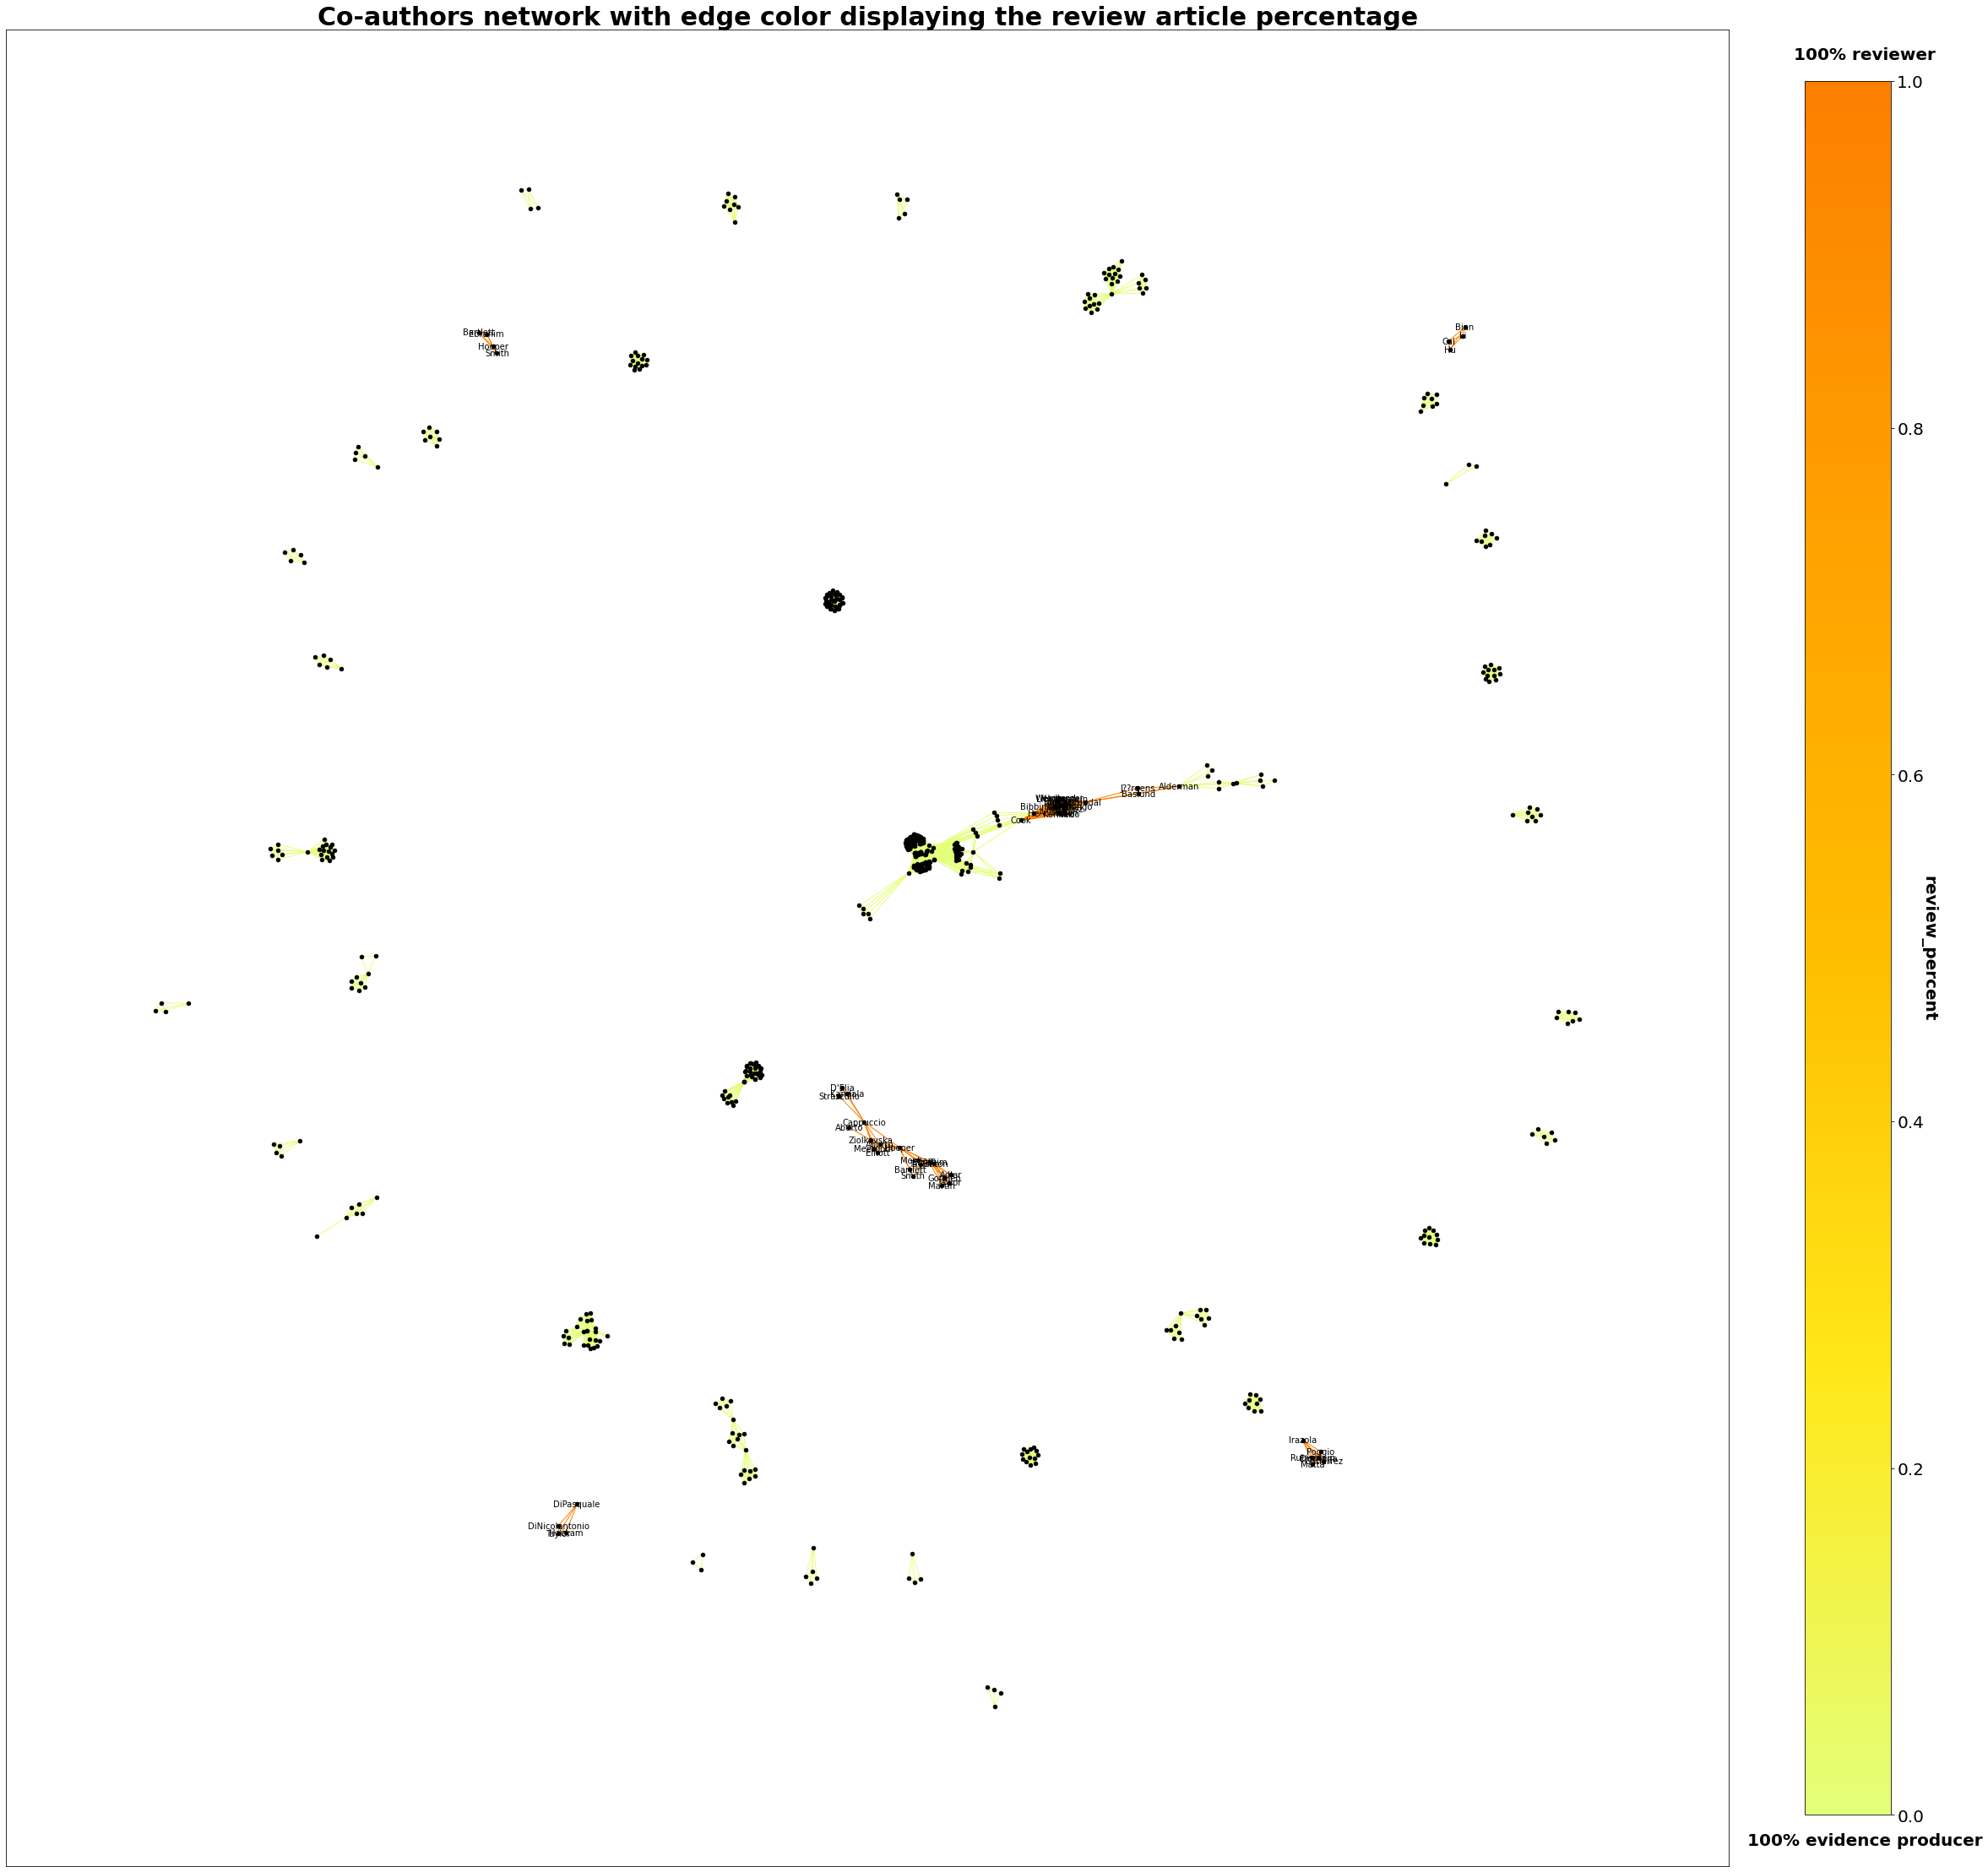

In [25]:
# Label nodes for authors who have higher published review articles
label_nodes = []

for e in G.edges():
    if G.get_edge_data(e[0],e[1])['review_percent'] >= 0.9:
        label_nodes.append(e[0])
        label_nodes.append(e[1])

label_nodes = list(set(label_nodes))
label_nodes

labels = {}
# splits the last name from the author name to be displayed in the graph
for node in G.nodes():
    if node in label_nodes:
        labels[node] = node.split(" ")[-1]

edges,weights = zip(*nx.get_edge_attributes(G,'review_percent').items())

# Type of the graph and drawing the node, edges along with the attributes and color for the node with labels for the overall graph
# The graph (G) can be replaced to get the graph of only top four components as commented in the below chunk
pos = nx.spring_layout(G,scale = 100)
nodes = nx.draw_networkx_nodes(G, pos=pos,node_size = 20, node_color="black")
edges_1 = nx.draw_networkx_edges(G,pos=pos, edgelist=edges, edge_color=weights,  edge_cmap=plt.cm.Wistia)
nx.draw_networkx_labels(G, pos,labels,font_size=10,font_color='black')

# plt.Figure(figsize=(15,18))

plt.sci(edges_1)

# set the colorbar attributes
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(0.0,1.0)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('review_percent', rotation=270,size=20,weight='bold' )
cbar.ax.text(0.7, -0.01, '100% evidence producer', va='top', ha='center', size=20, weight='bold')
cbar.ax.text(0.7, 1.02, '100% reviewer', va='top', ha='center', size=20, weight='bold')

# set the title and figsize for the graph
plt.title("Co-authors network with edge color displaying the review article percentage", size = 30, weight = 'bold')
plt.rcParams["figure.figsize"] = [40, 40]
plt.rcParams["figure.autolayout"] = False

plt.savefig(r"C:\Users\mansj\IQL\salt\Coauthor Network Visualization\Visualizations\edge_color_review.pdf", dpi = 800)


#### Visualization for top four connected components of the overall graph. There are no 100% reviewers present in the top four connected components. Uncomment the below to run

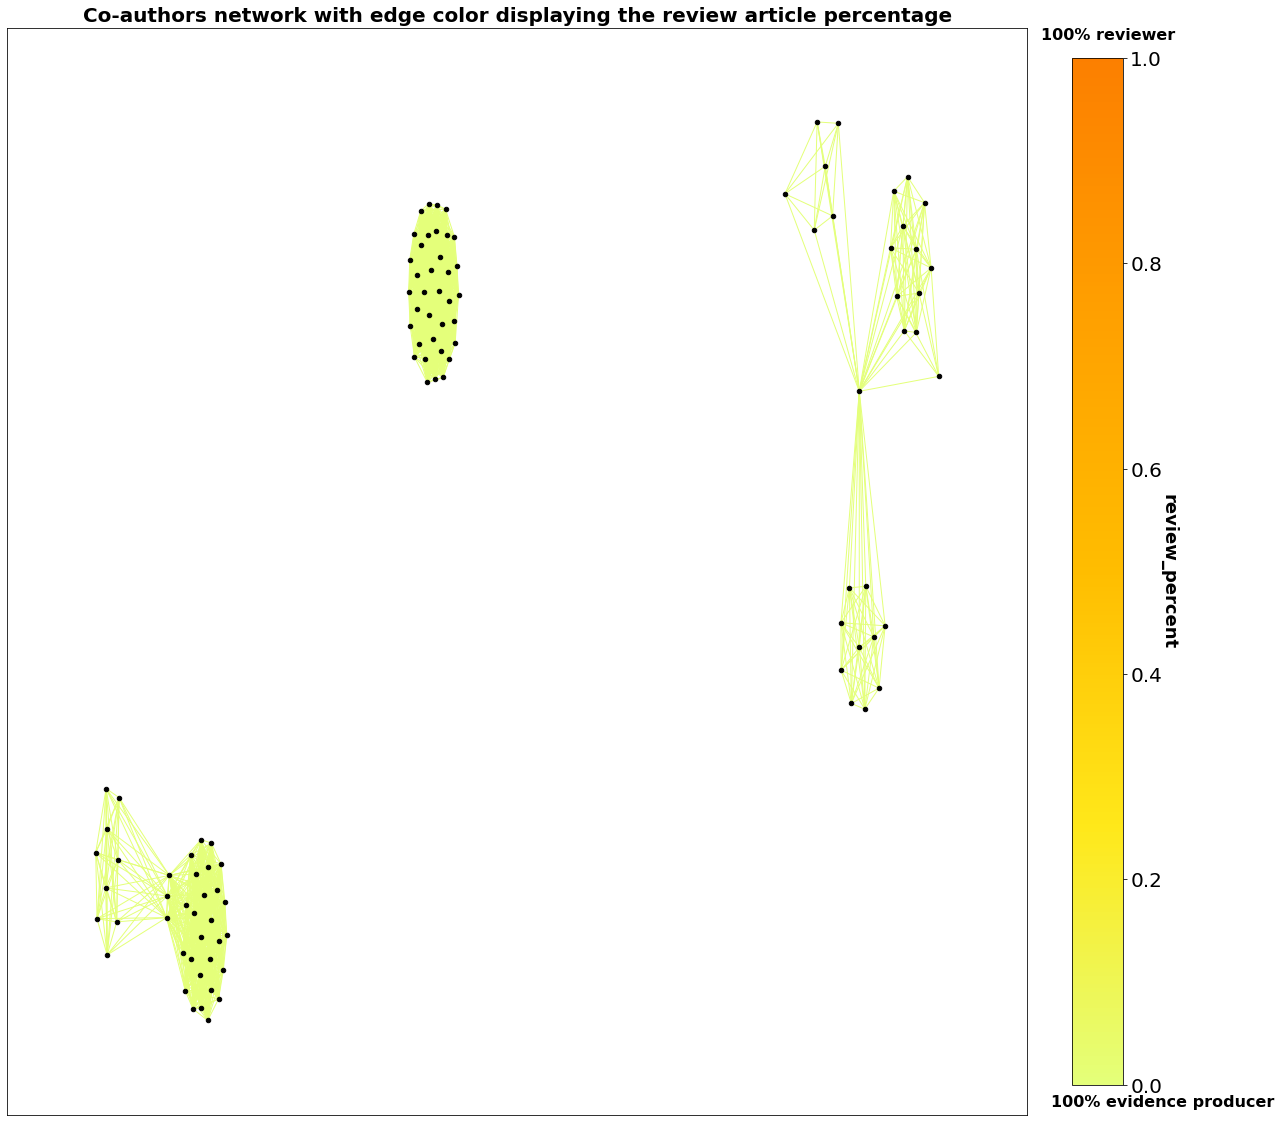

In [51]:
# # Label nodes for authors who have higher published review articles
# label_nodes = []

# for e in N.edges():
#     if N.get_edge_data(e[0],e[1])['weight'] >= 0.9:
#         label_nodes.append(e[0])
#         label_nodes.append(e[1])

# label_nodes = list(set(label_nodes))
# label_nodes

# labels = {}
# # splits the last name from the author name to be displayed in the graph
# for node in N.nodes():
#     if node in label_nodes:
#         labels[node] = node.split(" ")[-1]

# edges,weights = zip(*nx.get_edge_attributes(N,'weight').items())

# # Type of the graph and drawing the node, edges along with the attributes and color for the node with labels for the overall graph
# # The graph (G) can be replaced to get the graph of only top four components as commented in the below chunk
# pos = nx.spring_layout(N,scale = 100)
# nodes = nx.draw_networkx_nodes(N, pos=pos,node_size = 20, node_color="black")
# edges_1 = nx.draw_networkx_edges(N,pos=pos, edgelist=edges, edge_color=weights,  edge_cmap=plt.cm.Wistia)
# nx.draw_networkx_labels(N, pos,labels,font_size=10,font_color='black')

# # plt.Figure(figsize=(15,18))

# plt.sci(edges_1)

# # set the colorbar attributes
# cbar = plt.colorbar(fraction=0.046, pad=0.04)
# plt.clim(0.0,1.0)
# for t in cbar.ax.get_yticklabels():
#      t.set_fontsize(20)
# cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel('review_percent', rotation=270,size=18,weight='bold' )
# cbar.ax.text(-0.4, -0.01, '100% evidence producer', va='top', ha='left', size=16, weight='bold')
# cbar.ax.text(0.7, 1.03, '100% reviewer', va='top', ha='center', size=16, weight='bold')

# # set the title and figsize for the graph
# plt.title("Co-authors network with edge color displaying the review article percentage", size = 20, weight = 'bold')
# plt.rcParams["figure.figsize"] = [20, 20]
# plt.rcParams["figure.autolayout"] = False

# plt.savefig(r"C:\Users\mansj\IQL\salt\Coauthor Network Visualization\Visualizations\edge_color_top_4.pdf", dpi = 800)


#### Calculate the review article type percent for each author (i.e. node of the graph) and add as an attribute to the node

In [54]:
new_auth  = {}
r_count = 0
i_count = 0
for i in range(1,len(merged_type_df)):
    name = merged_type_df["full_name"].loc[i]
    type_t = merged_type_df["item_type"].loc[i]
    if type_t == "Systematic Review":
        r_count = 1
    else:
        i_count = 1
    if len(name) >= 2:
        for subset in itertools.combinations(name,2):
            if len(subset) == 2:
                
                subset = tuple(sorted(subset))
                for i in subset:
                    if i not in new_auth.keys():
                        new_auth[i] = (r_count, i_count)
                    else:
                        new_auth[i] = (new_auth[i][0] + r_count, new_auth[i][1] + i_count)
                    

df_new = pd.DataFrame(new_auth.items(), columns=['authors','counts'])
df_new[['reviews', 'study']] = pd.DataFrame(df['counts'].tolist(), index=df.index)

df_new['total'] = df_new['reviews'] + df_new['study']
df_new['review'] = round(df_new['reviews']/df_new['total'],2)

df_attr_node = df_new[['authors','review']]
node_attr = df_attr_node.set_index('authors').to_dict('index')
nx.set_node_attributes(G, node_attr, name = "review_percent")

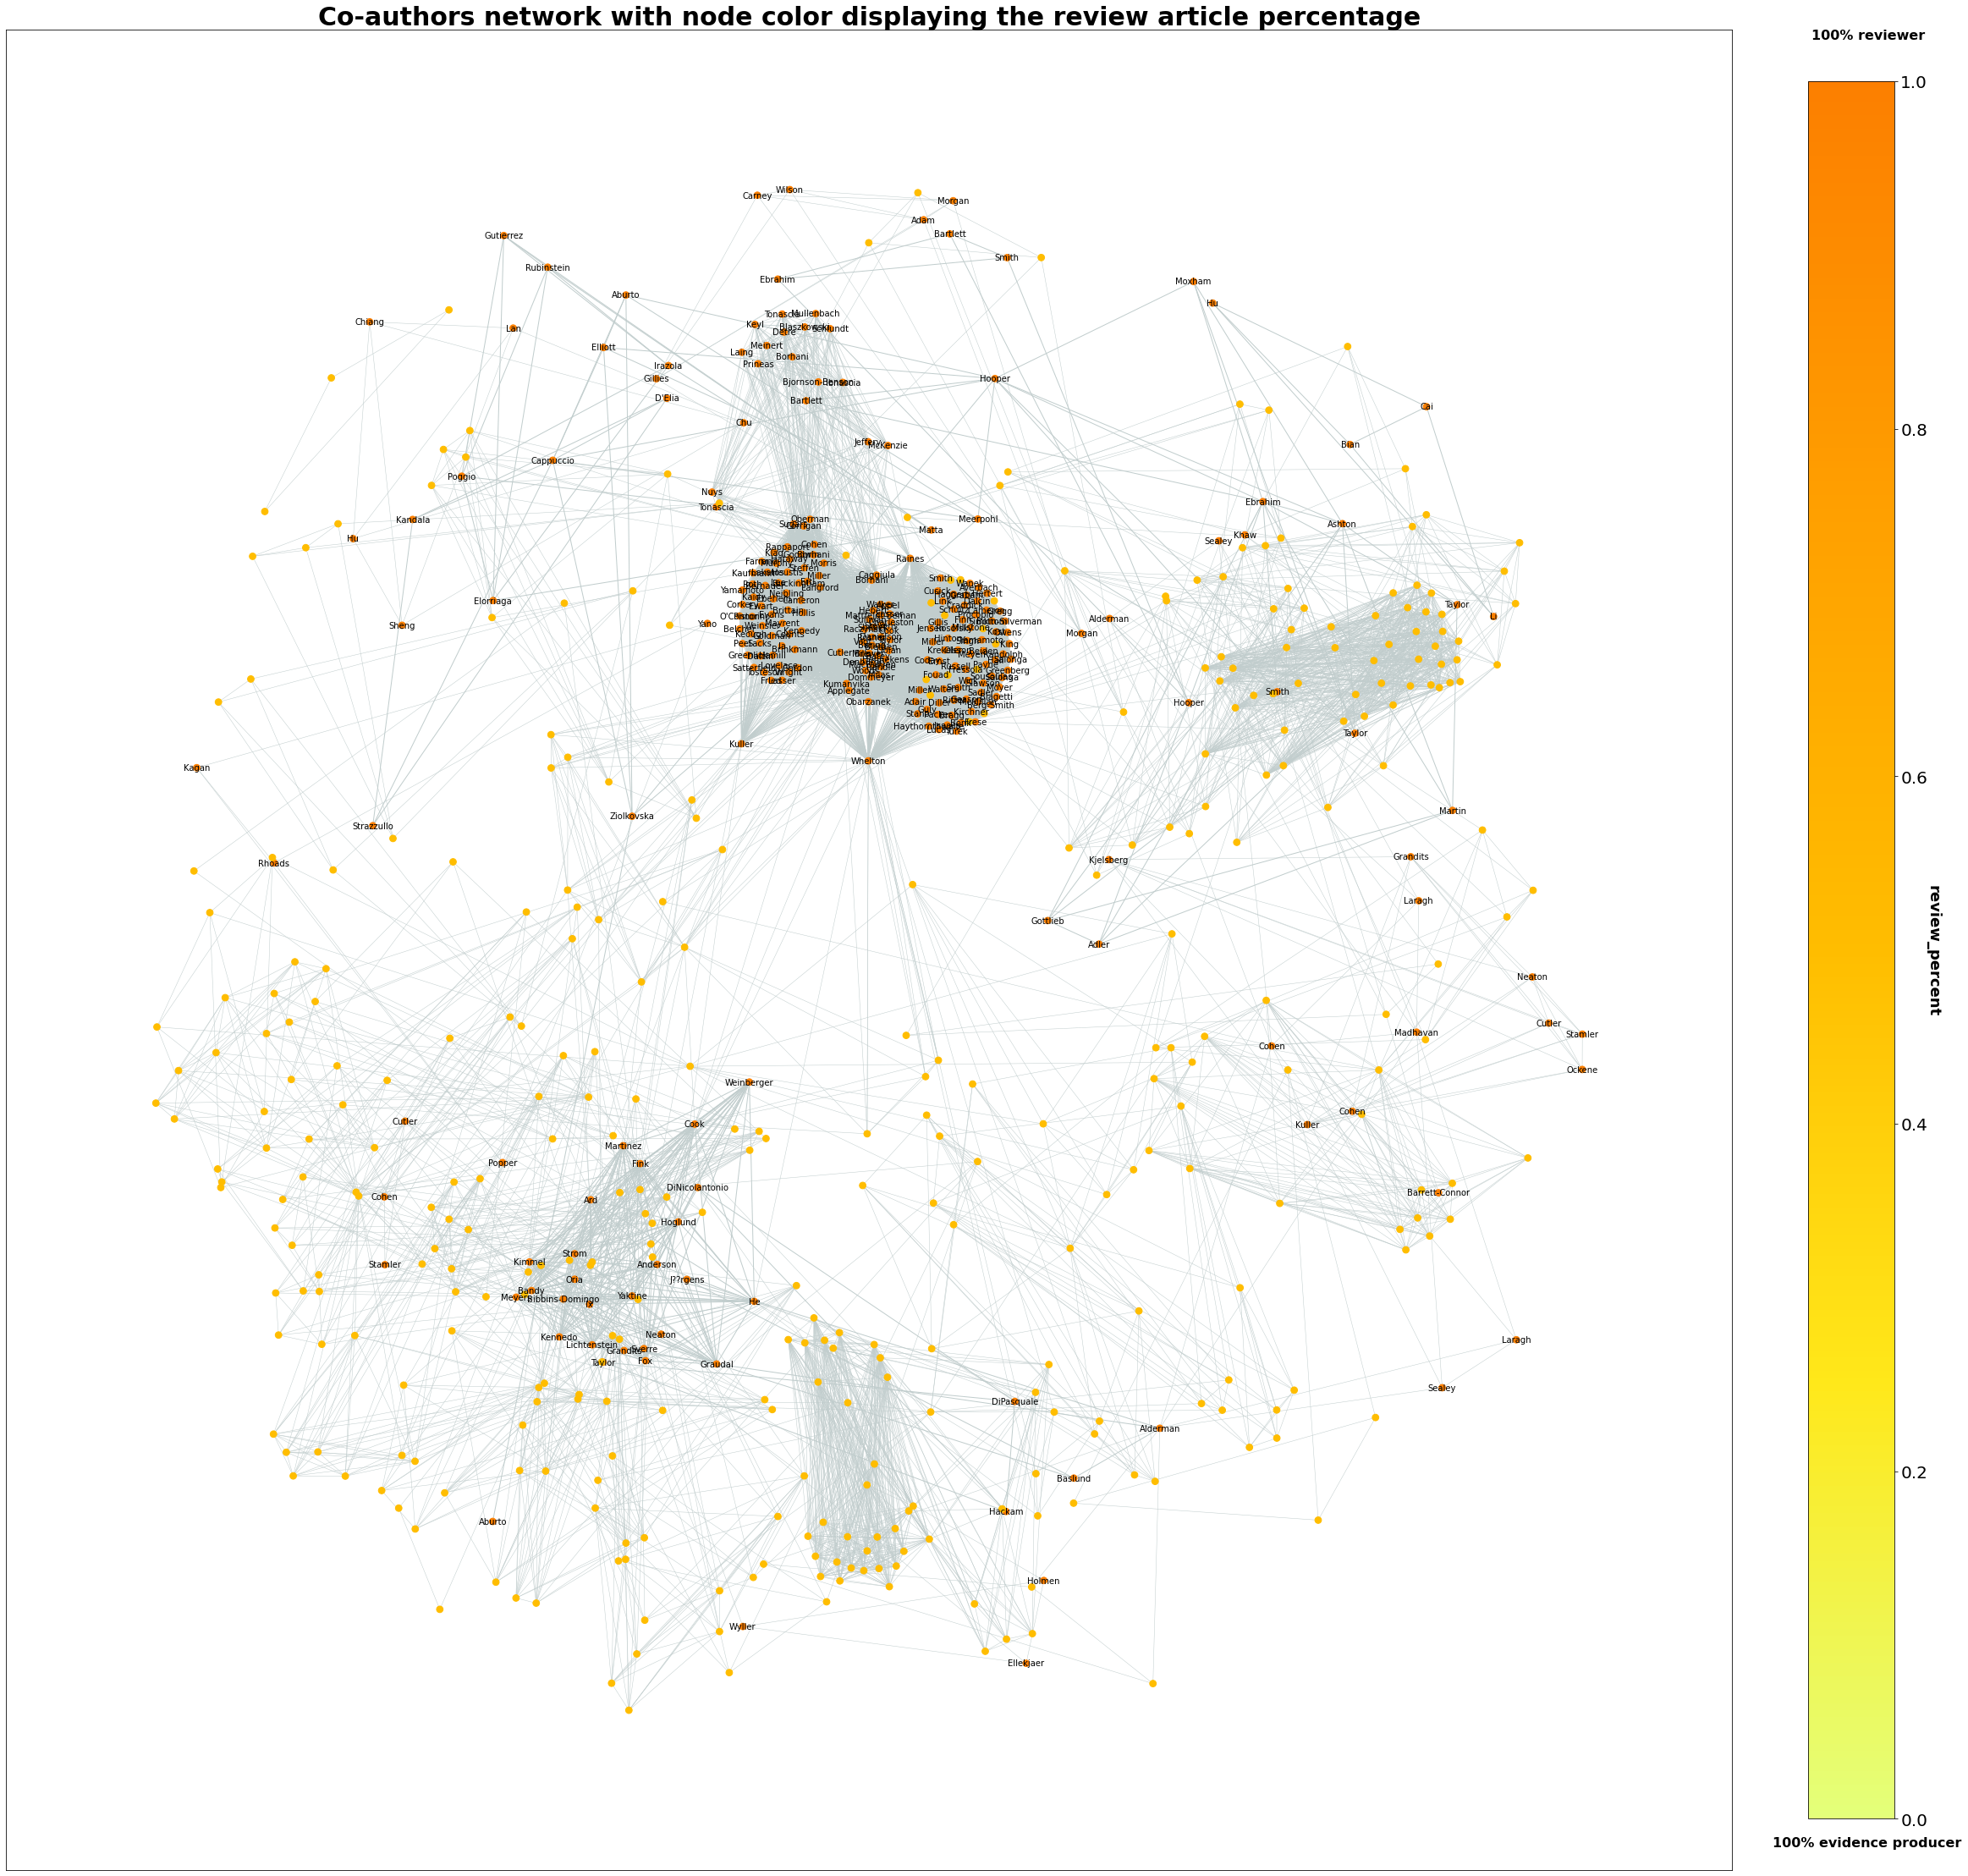

In [85]:
label_nodes = []

for n in G.nodes():
    if G.nodes[n]["review_percent"]['review'] >= 0.8:
        label_nodes.append(n)

label_nodes = list(set(label_nodes))
label_nodes

labels = {}

for node in G.nodes():
    if node in label_nodes:
        labels[node] = node.split(" ")[-1]

edges,weights = zip(*nx.get_edge_attributes(G,'review_percent').items())
nodes, r_pct = zip(*nx.get_node_attributes(G,'review_percent').items())

node_weight = []
for r in r_pct:
    node_weight.append(r['review'])

pos = nx.spring_layout(G, k=0.35, scale = 500)
nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes, node_size=60, node_color=node_weight, cmap = plt.cm.Wistia)
edges_1 = nx.draw_networkx_edges(G,pos=pos, node_size = 10, width=weights, edgelist=edges, edge_color = '#C1CDCD')
nx.draw_networkx_labels(G, pos,labels,font_size=10,font_color='black')

# plt.Figure(figsize=(15,18))

plt.sci(nodes)

# set the colorbar attributes
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(0.0,1.0)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('review_percent', rotation=270,size=18,weight='bold' )
cbar.ax.text(-0.4, -0.01, '100% evidence producer', va='top', ha='left', size=16, weight='bold')
cbar.ax.text(0.7, 1.03, '100% reviewer', va='top', ha='center', size=16, weight='bold')

plt.title("Co-authors network with node color displaying the review article percentage", size = 30, weight = 'bold')
plt.rcParams["figure.figsize"] = [40, 40]
plt.rcParams["figure.autolayout"] = False

plt.savefig(r"C:\Users\mansj\IQL\salt\Coauthor Network Visualization\Visualizations\node_color_review.pdf", dpi = 800)


#### Visualization for top four connected components of the overall graph. There are no 100% reviewers present in the top four connected components. Uncomment the below to run

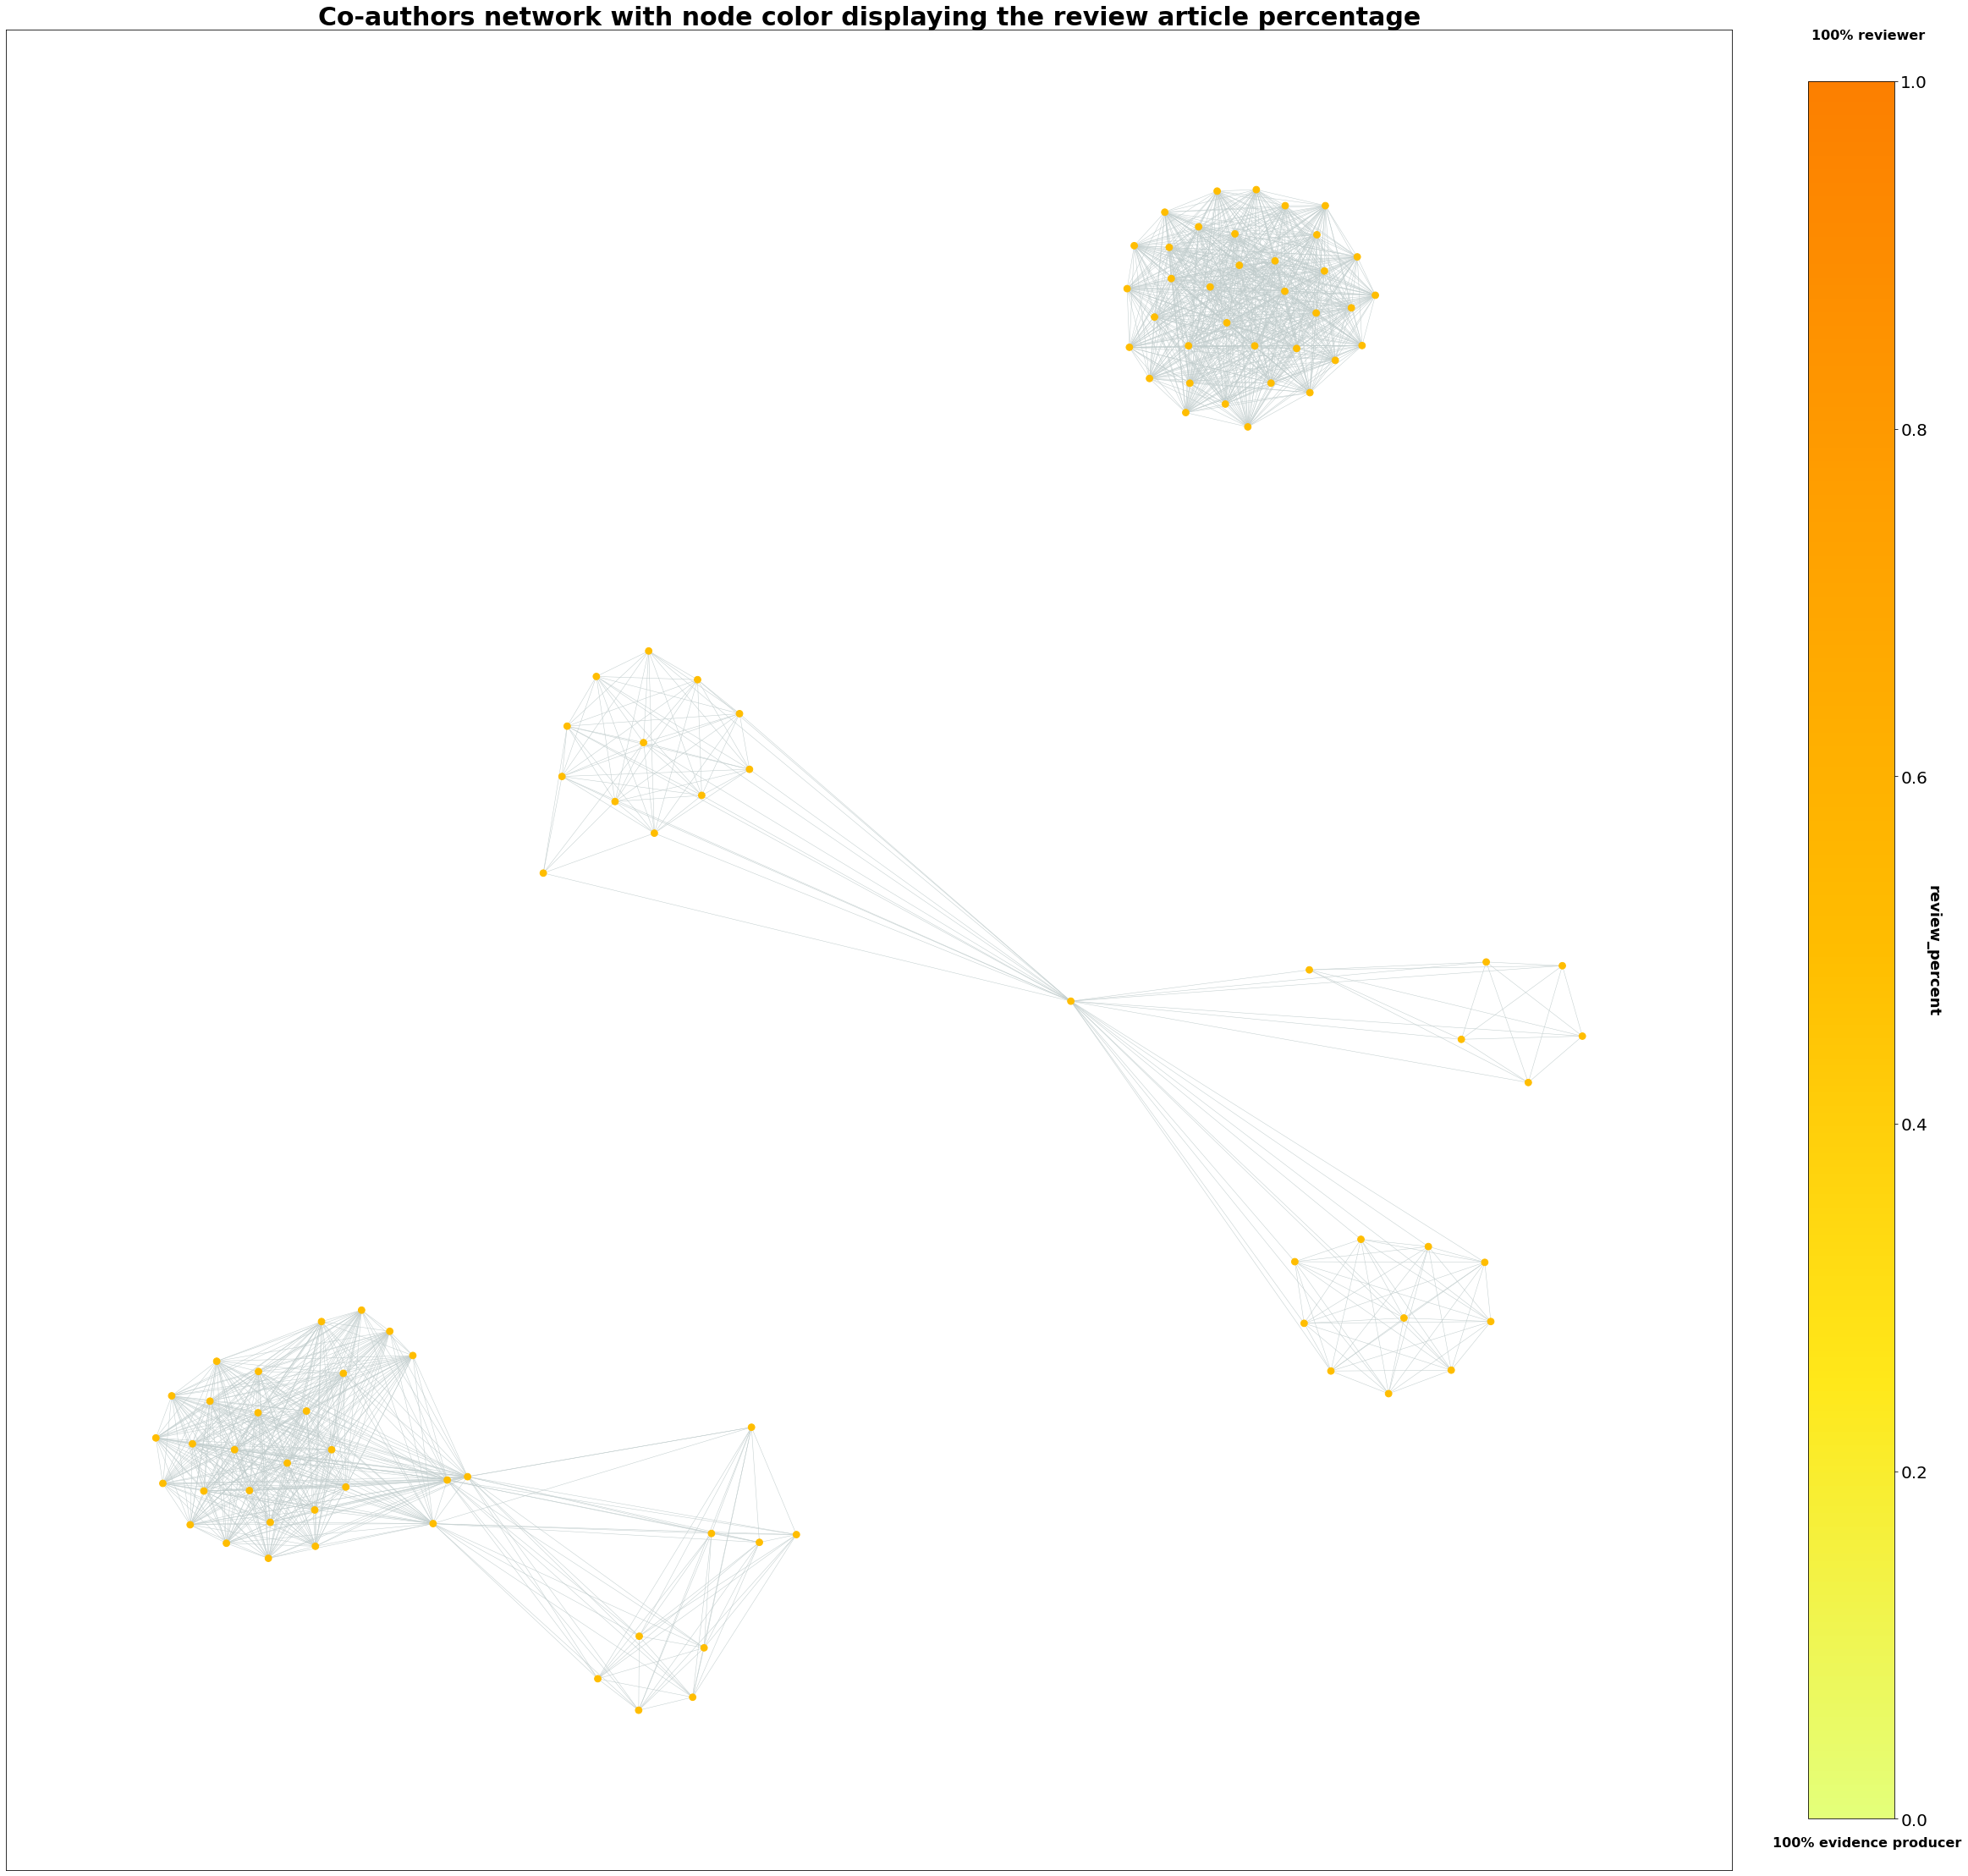

In [86]:
# label_nodes = []

# for n in N.nodes():
#     if N.nodes[n]["review_percent"]['review'] >= 0.8:
#         label_nodes.append(n)

# label_nodes = list(set(label_nodes))
# label_nodes

# labels = {}

# for node in N.nodes():
#     if node in label_nodes:
#         labels[node] = node.split(" ")[-1]

# edges,weights = zip(*nx.get_edge_attributes(N,'weight').items())
# nodes, r_pct = zip(*nx.get_node_attributes(N,'review_percent').items())

# node_weight = []
# for r in r_pct:
#     node_weight.append(r['review'])

# pos = nx.spring_layout(N, k=0.35, scale = 500)
# nodes = nx.draw_networkx_nodes(N, pos=pos, nodelist=nodes, node_size=60, node_color=node_weight, cmap = plt.cm.Wistia)
# edges_1 = nx.draw_networkx_edges(N,pos=pos, node_size = 10, width=weights, edgelist=edges, edge_color = '#C1CDCD')
# nx.draw_networkx_labels(N, pos,labels,font_size=10,font_color='black')

# # plt.Figure(figsize=(15,18))

# plt.sci(nodes)

# # set the colorbar attributes
# cbar = plt.colorbar(fraction=0.046, pad=0.04)
# plt.clim(0.0,1.0)
# for t in cbar.ax.get_yticklabels():
#      t.set_fontsize(20)
# cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel('review_percent', rotation=270,size=18,weight='bold' )
# cbar.ax.text(-0.4, -0.01, '100% evidence producer', va='top', ha='left', size=16, weight='bold')
# cbar.ax.text(0.7, 1.03, '100% reviewer', va='top', ha='center', size=16, weight='bold')

# plt.title("Co-authors network with node color displaying the review article percentage", size = 30, weight = 'bold')

# plt.rcParams["figure.figsize"] = [40, 40]
# plt.rcParams["figure.autolayout"] = False

# plt.savefig(r"C:\Users\mansj\IQL\salt\Coauthor Network Visualization\Visualizations\node_color_top_4.pdf", dpi = 800)
